In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import torch

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import StratifiedKFold

#### Read Kaggle data

In [2]:
id_map = pd.read_csv('data/id_map.csv',
                     index_col='id')

de_train = pd.read_parquet('data/de_train.parquet')
genes = de_train.columns[5:] # 18211 genes
de_train

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,NK cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.104720,-0.077524,-1.625596,-0.144545,0.143555,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,T cells CD4+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.915953,-0.884380,0.371834,-0.081677,-0.498266,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,T cells CD8+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,-0.387721,-0.305378,0.567777,0.303895,-0.022653,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,T regulatory cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.232893,0.129029,0.336897,0.486946,0.767661,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,NK cells,Mometasone Furoate,LSM-3349,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,False,4.290652,-0.063864,-0.017443,-0.541154,0.570982,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,T regulatory cells,Atorvastatin,LSM-5771,CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F...,False,-0.014372,-0.122464,-0.456366,-0.147894,-0.545382,...,-0.549987,-2.200925,0.359806,1.073983,0.356939,-0.029603,-0.528817,0.105138,0.491015,-0.979951
610,NK cells,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,-0.455549,0.188181,0.595734,-0.100299,0.786192,...,-1.236905,0.003854,-0.197569,-0.175307,0.101391,1.028394,0.034144,-0.231642,1.023994,-0.064760
611,T cells CD4+,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,0.338168,-0.109079,0.270182,-0.436586,-0.069476,...,0.077579,-1.101637,0.457201,0.535184,-0.198404,-0.005004,0.552810,-0.209077,0.389751,-0.337082
612,T cells CD8+,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,0.101138,-0.409724,-0.606292,-0.071300,-0.001789,...,0.005951,-0.893093,-1.003029,-0.080367,-0.076604,0.024849,0.012862,-0.029684,0.005506,-1.733112


In [32]:
lincs = torch.load("data/lincs_pretreatment.pt")
lincs[0].keys()

dict_keys(['pert_iname', 'cell_id', 'pert_idose', 'pert_itime', 'canonical_smiles', 'control', 'pre_treatment', 'post_treatment'])

In [33]:
kaggle = torch.load("data/kaggle_pretreatment.pt")
kaggle[0].keys()

dict_keys(['cell_type', 'sm_name', 'sm_lincs_id', 'SMILES', 'control', 'pre_treatment', 'post_treatment', 'transcriptome'])

In [36]:
lincs_uniques = {
    key: list({d[key]
               for d in lincs})
    for key in ["cell_id", "pert_iname"]
}
{k: len(lincs_uniques[k]) for k in lincs_uniques.keys()}

{'cell_id': 30, 'pert_iname': 1768}

In [37]:
kaggle_uniques = {
    key: list({d[key]
               for d in kaggle})
    for key in ["cell_type", "sm_name"]
}
{k: len(kaggle_uniques[k]) for k in kaggle_uniques.keys()}

{'cell_type': 6, 'sm_name': 144}

In [40]:
cell_types = list(set(lincs_uniques["cell_id"] + kaggle_uniques["cell_type"]))
smiles_types = list(
    set(lincs_uniques["pert_iname"] + kaggle_uniques["sm_name"]))
len(cell_types), len(smiles_types)

(36, 1896)

In [41]:
smile_map = de_train[["sm_name","SMILES"]].set_index("sm_name").to_dict()["SMILES"]
len(smile_map)

146

### Prepare train data for folds

In [43]:
B_M_df = de_train[de_train["cell_type"].isin(["B cells", "Myeloid cells"])].reset_index(drop=True)
mean_score = B_M_df[["sm_name"]+genes.tolist()].groupby("sm_name").agg("mean").mean(axis=1)
classes = np.digitize(mean_score.values, bins=[0.1, 0.5, 1])
cpds = mean_score.index.values
fold_arr = np.full(len(cpds), -1)
skf = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
for fold, (trn_ind, val_ind) in enumerate(skf.split(classes, classes)):
    fold_arr[val_ind] = fold
fold_map = {c: f for c, f in zip(cpds, fold_arr)}
fold_to_cpds = {fold: cpds[fold_arr==fold] for fold in range(3)}

fold_to_cpds

{0: array(['Alvocidib', 'Belinostat', 'Foretinib', 'LDN 193189',
        'Linagliptin', 'O-Demethylated Adapalene'], dtype=object),
 1: array(['Dabrafenib', 'Dactolisib', 'Idelalisib', 'MLN 2238',
        'Palbociclib', 'Porcn Inhibitor III'], dtype=object),
 2: array(['CHIR-99021', 'Crizotinib', 'Oprozomib (ONX 0912)', 'Penfluridol',
        'R428'], dtype=object)}

### Prepare LINCS data for folds

In [152]:
lincs_df = pd.DataFrame.from_records(lincs,exclude=["pre_treatment","post_treatment"])
lincs_df = lincs_df.rename(columns={"pert_iname":"sm_name","cell_id":"cell_type"})
# Contains multiple measurements (at different doses etc)
lincs_df = lincs_df.drop_duplicates()
lincs_df

,sm_name,cell_type,pert_idose,pert_itime,canonical_smiles,control
0,10-DEBC,A375,10.0 um,24 h,CCN(CC)CCCCN1c2ccccc2Oc2ccc(Cl)cc12,False
1,10-DEBC,A375,3.33 um,24 h,CCN(CC)CCCCN1c2ccccc2Oc2ccc(Cl)cc12,False
2,10-DEBC,A375,1.11 um,24 h,CCN(CC)CCCCN1c2ccccc2Oc2ccc(Cl)cc12,False
3,10-DEBC,A375,0.37 um,24 h,CCN(CC)CCCCN1c2ccccc2Oc2ccc(Cl)cc12,False
4,10-DEBC,A375,0.12 um,24 h,CCN(CC)CCCCN1c2ccccc2Oc2ccc(Cl)cc12,False
...,...,...,...,...,...,...
107389,smer-3,A375,10.0 um,6 h,O=C1c2ccccc2-c2nc3nonc3nc12,False
107392,smer-3,MCF7,10.0 um,6 h,O=C1c2ccccc2-c2nc3nonc3nc12,False
107395,smer-3,NPC.TAK,10.0 um,6 h,O=C1c2ccccc2-c2nc3nonc3nc12,False
107398,smer-3,A549,10.0 um,6 h,O=C1c2ccccc2-c2nc3nonc3nc12,False


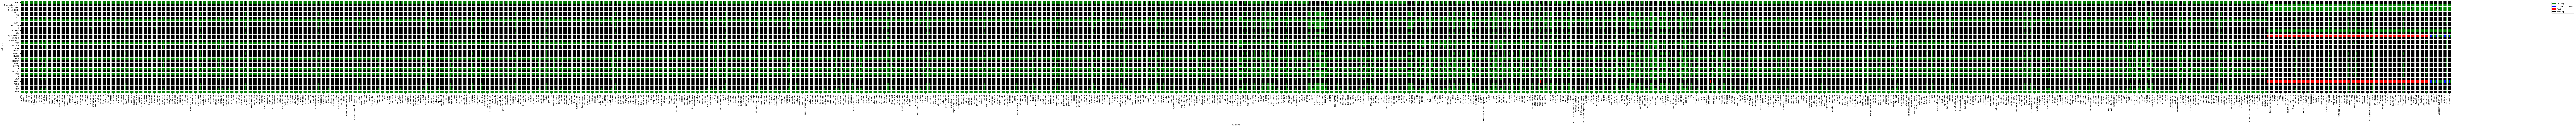

In [180]:
def plot_cv_diagram(fold, fold_to_cpds):
    cv_diagram = pd.concat([df[['cell_type', 'sm_name']] for df in [lincs_df,de_train,id_map]], axis=0, keys=[2,2,1])
    cv_diagram = cv_diagram.reset_index().drop(columns=['level_1'])
    
    # LINCS data contains multiple measurements for (cell_type,sm_name) differentiated by dose, and time
    # Drop those here
    cv_diagram = cv_diagram.drop_duplicates()
    cv_diagram = cv_diagram.pivot(index='cell_type', columns='sm_name')
    cv_diagram.fillna(0, inplace=True)
    cv_diagram = cv_diagram.droplevel(level=0, axis=1)
    cv_diagram = cv_diagram.sort_values('Myeloid cells', axis=1)
    cv_diagram = cv_diagram.sort_index(ascending=False)
#     cv_diagram.loc[val_cell_type] *= 1 + (cv_diagram.loc[['Myeloid cells', 'B cells']] == 1).any().astype(float) * 0.5
    cpds_fold = fold_to_cpds[fold].tolist()
    cv_diagram.loc[['Myeloid cells', 'B cells'], cpds_fold] = 3
    # 0=Missing
    # 1=Test
    # 2=Training
    # 3=Validation
    fig, (ax1, ax2) = plt.subplots(1, 2, width_ratios=(20, 1), figsize=(200, 10))
    sns.heatmap(cv_diagram, cbar=False, linewidths=1, ax=ax1, cmap=['k', 'r', 'g', 'b'])
    
    ax2.legend(handles=[mpatches.Patch(color='g', label='Training'),
                        mpatches.Patch(color='b', label=f'Validation (fold {fold})'),
                        mpatches.Patch(color='r', label='Test'),
                        mpatches.Patch(color='k', label='Missing')])
    ax2.axis('off')
    fig.tight_layout()
    plt.show()

# Girls when they make a beautiful diagram
plot_cv_diagram(0, fold_to_cpds)